## Dataset & augmentation

In [1]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=21caadf5cd385cf89b197a81b029627ac8bc7504df8602ab33ae96096e7049c2
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [2]:
import wget

# The dataset we used belongs Leaf Segmentation and Counting Challenge (LCC and LSC). 
# It is publicly available at https://www.plant-phenotyping.org/CVPPP2017. 
# The download links to the data are saved to dataset_urls.txt file.

train_truth_url, train_url, test_url = open("dataset_urls.txt").readlines()

train_h5 = wget.download(train_url)
train_truth_h5 = wget.download(train_truth_url)
test_h5 = wget.download(test_url)


In [43]:
# !unzip *.zip

!unzip './CVPPP2017_training_images.zip' './CVPPP2017_training_truth.zip' './CVPPP2017_testing_images.zip'

Archive:  CVPPP2017_testing_images.zip
caution: filename not matched:  CVPPP2017_training_images.zip
caution: filename not matched:  CVPPP2017_training_truth.zip


In [36]:
import h5py
import numpy as np

groups = ['A1', 'A2', 'A3']

train_filename = 'CVPPP2017_training_images.h5'
train_imgs = []
with h5py.File(train_filename, "r") as f:
    for group in groups:
        for file_name in list(f[group]):
            train_imgs.append(np.array(f[group][file_name]['rgb']))


train_truth_filename = 'CVPPP2017_training_truth.h5'
train_counts = []
train_masks = []
with h5py.File(train_truth_filename, "r") as f:
    for group in groups:
        for file_name in list(f[group]):
            train_counts.append(np.array(f[group][file_name]['count']))
            train_masks.append(np.clip(np.array(f[group][file_name]['label']), 0, 1))

In [37]:
print(len(train_imgs), len(train_counts), len(train_masks))

186 186 186


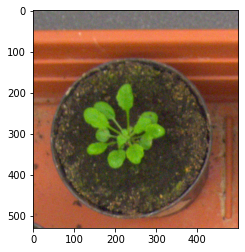

In [38]:
import matplotlib.pyplot as plt

plt.imshow(train_imgs[0])

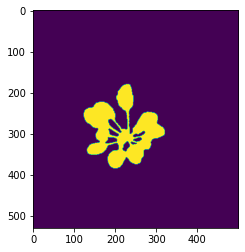

In [39]:
plt.imshow(np.clip(train_masks[0], 0, 1))

In [41]:
# the number of leafs
print(train_counts[0])

15


In [45]:
## Augmentation to be implemented

# Augmentation types from paper:
# (1) Random-Rotate with an interval of 90 to increase the network invariance to slight angular changes; 
# (2) Flip: horizontal, vertical, and horizontal+ vertical; 
# (3) Resize the images to increase the network invariance to different image resolutions; 
# (4) Gamma transform to extend the data by changing the image greyscale; 
# (5) Random-Brightness: the clarity of object depends on scene lighting and camera sensitivity,
# (6) Random change in the contrast range to increase the network invariance to shadows and improve the network performance in low light conditions; 
# (7) Hue Saturation Brightness (HSV): changes in colour channels, degree of lightness or darkness of a colour; and 
# (8) Normalise a characteristic linear transformation which scales a specific range of data values retaining the original data distribution

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class LeafDataset(Dataset):
    def __init__(self, transforms=True):
        super().__init__()
        self.images = ...
        self.masks = ...
        if transforms:
            self.transforms = transforms.Compose(...)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.transforms(self.images[idx]), self.transforms(self.images[idx])


In [52]:
batch_size = 4
train_size = 0.8
dataset_len = len(train_imgs)

train_iter = list(zip(train_imgs, train_counts, train_masks))[:int(dataset_len * train_size)]
test_iter = list(zip(train_imgs, train_counts, train_masks))[int(dataset_len * train_size):]

train_dl = DataLoader(train_iter, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_iter, batch_size=batch_size, shuffle=False)

## Build models

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from time import time
from tqdm.notebook import tqdm

In [54]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on {device} device')

Working on cpu device


In [55]:
# First stream network

import torchvision.models as models

resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [66]:
for param in resnet50.parameters():
    param.requires_grad = False

# We will stack the 3 channels of the input image with the mask. Thus, 4 channels in total.
resnet50.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=2, padding=3, bias=False)
for param in resnet50.conv1.parameters():
    param.requires_grad = True

# We will solve regression problem
resnet50.fc = torch.nn.Linear(2048, 1)
for param in resnet50.fc.parameters():
    param.requires_grad = True

In [68]:
# Second stream network

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv1 = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2)  # 256 -> 128
        
        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2)  # 128 -> 64

        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2)  # 64 -> 32

        self.enc_conv4 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        self.pool4 = nn.MaxPool2d(2, 2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(512, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU(),
                                       nn.Conv2d(1024, 1024, 3, padding=1), nn.BatchNorm2d(1024), nn.ReLU())

        # decoder (upsampling)
        self.upsample1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)  # 16 -> 32
        self.dec_conv1 = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
                                       nn.Conv2d(512, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        
        self.upsample2 = nn.ConvTranspose2d(512, 256, 2, stride=2)  # 16 -> 32
        self.dec_conv2 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                                       nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        
        self.upsample3 = nn.ConvTranspose2d(256, 128, 2, stride=2)  # 32 -> 64
        self.dec_conv3 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                                       nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU())

        self.upsample4 = nn.ConvTranspose2d(128, 64, 2, stride=2)   # 64 -> 128
        self.dec_conv4 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                                       nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                                       nn.Conv2d(64, 1, 1))


    def forward(self, x):
        # encoder
        e1 = self.enc_conv1(x)
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))
        e4 = self.enc_conv4(self.pool3(e3))

        # bottleneck
        b = self.bottleneck_conv(self.pool4(e4))

        # decoder
        d1 = self.dec_conv1(torch.concat([e4, self.upsample1(b)], 1))
        d2 = self.dec_conv2(torch.concat([e3, self.upsample2(d1)], 1))
        d3 = self.dec_conv3(torch.concat([e2, self.upsample3(d2)], 1))
        d4 = self.dec_conv4(torch.concat([e1, self.upsample4(d3)], 1))
        return torch.sigmoid(d4)

## Training

In [60]:
def loss_function(y_real, y_pred):
    # dice loss
    num = (y_real * y_pred).view(4, 1, -1).sum(2)
    den = (y_real + y_pred).view(4, 1, -1).sum(2)
    res = -2 * num / den
    dice = res.mean()

    # bce loss
    bce = (-0.5 * y_real * torch.log(y_pred)).sum(2).mean()
    return dice + bce

In [70]:
def train_segmentation(model_segm, model_count, epochs, loss_fn, opt, data_tr, data_val):
    
    train_segm_losses = []
    train_count_losses = []
    val_segm_losses = []
    val_count_losses = []

    for epoch in epochs:
        model_segm.train()
        model_count.train()
        for imgs, counts, masks in tqdm(data_tr):
            imgs, counts, masks = imgs.to(device), counts.to(device), masks.to(device)
            
            # Train segmentation
            opt.zero_grad()
            output = model_segm(imgs)
            loss = loss_fn(output, masks)
            loss.backward()
            opt.step()
            train_segm_losses.append(loss.item())

            # Train counts
            opt.zero_grad()
            output = model_count(torch.stack((imgs, masks)))
            loss = loss_fn(output, counts)
            loss.backward()
            opt.step()
            train_count_losses.append(loss.item())

        
        model_segm.eval()
        model_count.eval()
        with torch.no_grad():        
            for imgs, counts, masks in tqdm(data_val):
                imgs, counts, masks = imgs.to(device), counts.to(device), masks.to(device)
                # Evaluate segmentation
                output = model_segm(imgs)
                loss = loss_fn(output, masks)
                val_segm_losses.append(loss.item())

                # Evaluate counts
                output = model_count(torch.stack((imgs, masks)))
                loss = loss_fn(output, counts)
                val_count_losses.append(loss.item())
        print(f'Epoch: {epoch}, train loss: {train_segm_losses[-1], train_count_losses[-1]}, val loss: {val_segm_losses[-1], val_count_losses[-1]}')


In [ ]:
model_segm = UNet().to(device)
model_count = resnet50.to(device)

optimizer = optim.Adam(lr=1e-3, decay=1e-4)

In [ ]:
# Training 



## Evaluation

In [ ]:
## eval functions to be added

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

## Build web demo with Gradio library

In [ ]:
#!pip install gradio

In [5]:
import gradio as gr
import os


def predict_leaf_number(img):
    # preprocessing = ...
    return model_count(torch.stack((img, model_segm(img))))


with gr.Blocks() as demo:

    gr.Markdown("# Leaf counter")

    with gr.Row():
        im = gr.Image()
        txt = gr.Textbox(value='', label="Leaf number")

    btn = gr.Button(value="Mirror Image")
    btn.click(predict_leaf_number, inputs=[im], outputs=[txt])

    gr.Markdown("## Image Examples")
    # gr.Examples(
    #     examples=[os.path.join(os.path.dirname(__file__), "lion.jpg")],
    #     inputs=im,
    #     outputs=im_2,
    #     fn=mirror,
    #     cache_examples=True,
    # )

if __name__ == "__main__":
    demo.launch()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>